In [2]:
import pandas as pd
import numpy as np

Figure 2

# Data Loading

In [8]:
inventor_table = pd.read_csv('../data/raw/g_inventor_disambiguated.tsv', on_bad_lines= 'skip', sep ='\t')
assignee_table = pd.read_csv('../data/raw/g_assignee_disambiguated.tsv', on_bad_lines= 'skip', sep ='\t')

In [11]:
disruptive_tasks = pd.read_csv('../data/processed/ClassifiedTasks/disruptive_tasks.csv', on_bad_lines= 'skip')
consolidating_tasks = pd.read_csv('../data/processed/ClassifiedTasks/consolidating_tasks.csv', on_bad_lines= 'skip')


In [36]:
disruptive_tasks['patent_id'] = disruptive_tasks['patent_id'].astype(str)

In [37]:
consolidating_tasks['patent_id'] = consolidating_tasks['patent_id'].astype(str)

In [38]:
location_table = pd.read_csv('../data/raw/g_location_disambiguated.tsv', on_bad_lines = 'skip', sep = '\t')

In [39]:
tasks = pd.read_csv('../data/processed/tasks_matched_with_ai_patent_keywords_alicpc.csv')
quantile_threshold = tasks['patents_cosine_similarity'].quantile(0.9)
tasks_notexposedai = tasks[tasks['patents_cosine_similarity']<quantile_threshold]
tasks_exposedai = tasks[tasks['patents_cosine_similarity']>quantile_threshold]

In [40]:
tasks_exposedai['patent_id'] =tasks_exposedai['patent_id'].astype(str)

/tmp/ipykernel_1977/2269441982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] =tasks_exposedai['patent_id'].astype(str)


In [42]:
tasks_merge= pd.merge(tasks_exposedai,assignee_table, on ='patent_id',how='left' )


In [43]:
occupations = pd.read_csv('../data/raw/db_24_3_text/Occupation Level Metadata.txt', sep='\t')

In [47]:
occupations_naics_sector = occupations[occupations['Item'] == 'NAICS Sector']
occupations_naics_sector['SOC Code'] = occupations_naics_sector['O*NET-SOC Code'].apply(lambda x: x[:7])
occupations_naics_sector_trust = occupations_naics_sector[occupations_naics_sector['Percent']>50]
occupations_naics_sector_trust_max = occupations_naics_sector_trust.loc[occupations_naics_sector_trust.groupby('SOC Code')['Percent'].idxmax()]

In [48]:
soc_code_to_response = dict(zip(occupations_naics_sector_trust_max ['SOC Code'], occupations_naics_sector_trust_max ['Response']))



In [49]:
disruptive_tasks['SOC Code'] = disruptive_tasks['O*NET-SOC Code'].apply(lambda x: x[:7])
consolidating_tasks['SOC Code'] = consolidating_tasks['O*NET-SOC Code'].apply(lambda x: x[:7])

In [50]:
tasks_exposedai['SOC Code'] = tasks_exposedai['O*NET-SOC Code'].apply(lambda x: x[:7])

/tmp/ipykernel_1977/336808364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['SOC Code'] = tasks_exposedai['O*NET-SOC Code'].apply(lambda x: x[:7])


In [51]:
disruptive_tasks['task_industry'] = disruptive_tasks['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)

In [52]:
consolidating_tasks['task_industry'] = consolidating_tasks['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)

In [53]:
tasks_exposedai['task_industry'] = tasks_exposedai['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)

/tmp/ipykernel_1977/3228592285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['task_industry'] = tasks_exposedai['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)


In [54]:
disruptive_merged_df = pd.merge(disruptive_tasks, assignee_table, on='patent_id', how='left')
consolidating_merged_df = pd.merge(consolidating_tasks, assignee_table, on='patent_id', how='left')

In [55]:
disruptive_grouped_data = disruptive_merged_df  .groupby(['task_industry','disambig_assignee_organization']).size().reset_index(name='patents')
consolidating_grouped_data = consolidating_merged_df.groupby([ 'task_industry','disambig_assignee_organization']).size().reset_index(name='patents')


In [60]:
industry_proportions = tasks_exposedai['task_industry'].value_counts(normalize=True)

industry_counts_disruptive = disruptive_tasks['task_industry'].value_counts(normalize=True)
industry_counts_consolidating = consolidating_tasks['task_industry'].value_counts(normalize=True)


In [61]:
# Calculate the difference
difference = industry_counts_disruptive - industry_proportions

# Rank the difference by sorting the values
ranked_difference = difference.sort_values(ascending=False)

# Display the ranked difference
print(ranked_difference)

task_industry
Information                                                                 0.021564
Professional, Scientific and Technical Services                             0.017089
Administrative and support and waste management and remediation services    0.013927
Education services                                                          0.011016
Transportation and warehousing                                              0.008670
Finance and insurance                                                       0.006250
Utilities                                                                   0.005409
Public administration                                                       0.005213
Construction                                                                0.002538
Wholesale trade                                                            -0.000020
Retail trade                                                               -0.000880
Health care and social assistance                  

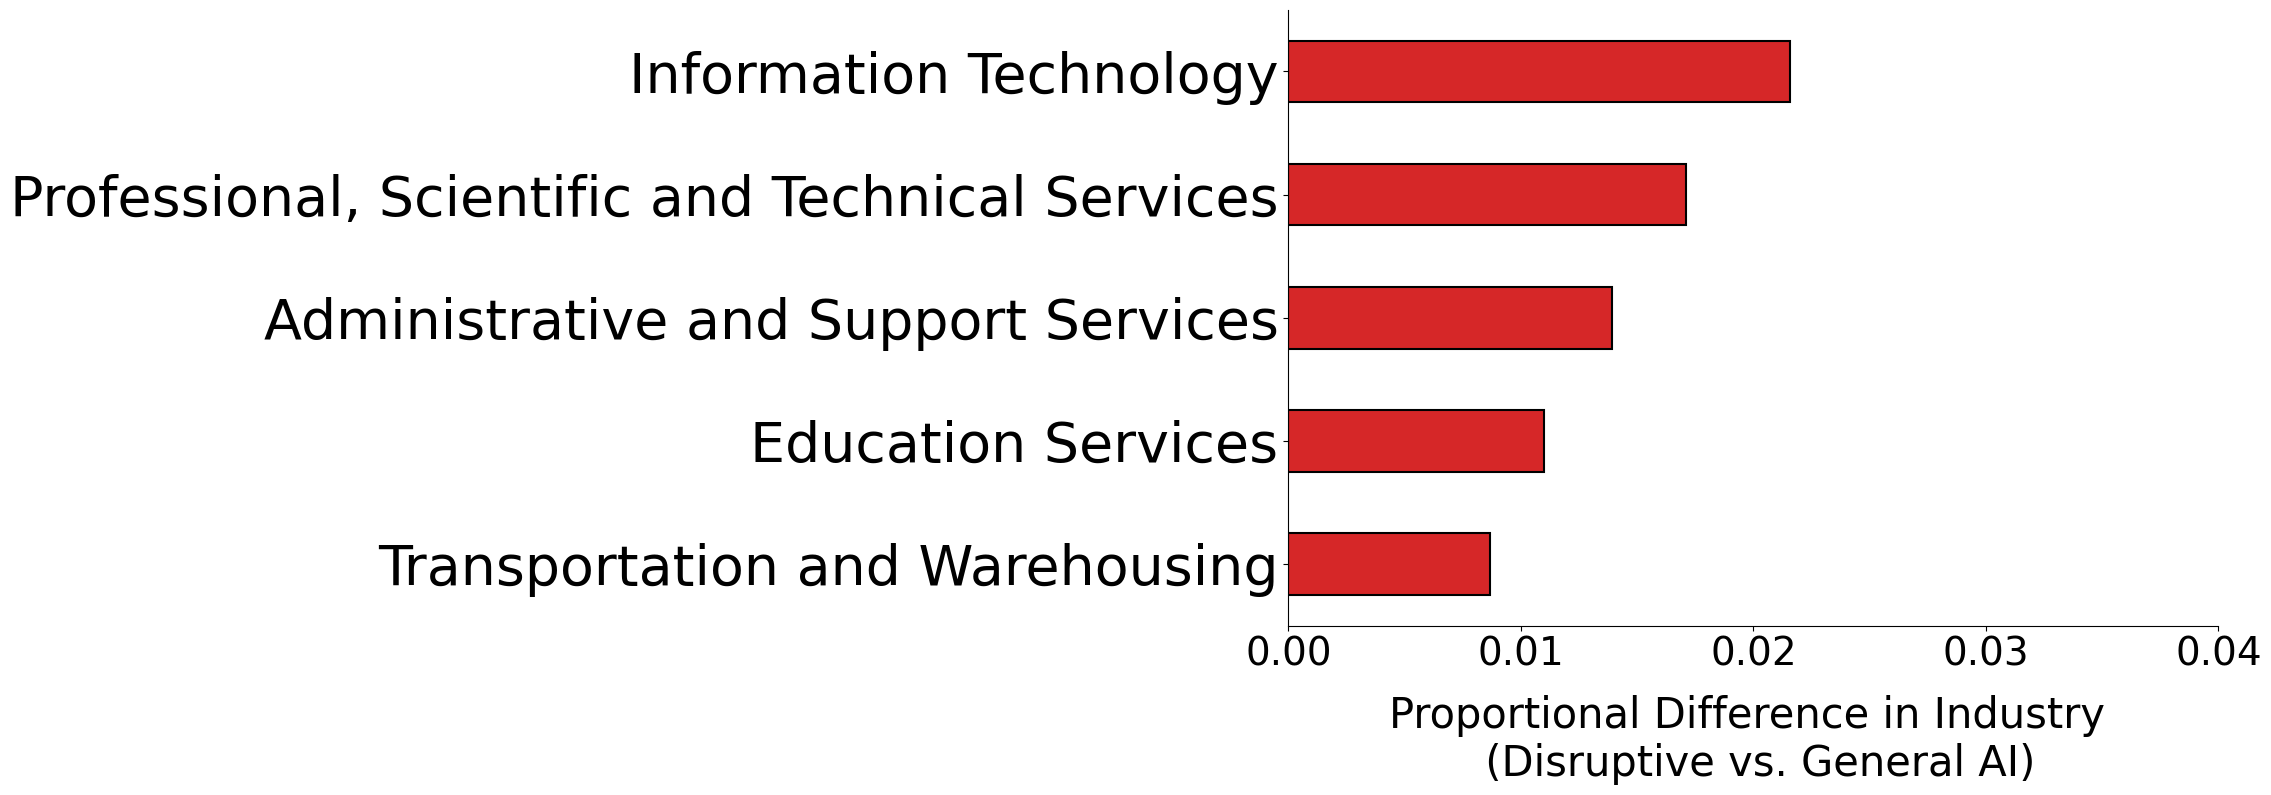

In [62]:
import matplotlib.pyplot as plt

# Set the style to a more professional one
plt.style.use('default')

# Define a color in a fancy red scheme
fancy_red = '#D62728'  # This is a deep red color that is often used in high-quality visualizations

# Create the figure and axis
plt.figure(figsize=(12, 8))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Plot the data
ranked_difference[:5].sort_values(ascending=True).plot(kind='barh', color=fancy_red, edgecolor='black', linewidth=1.5)

# Add labels and titles with larger font sizes
plt.xlabel('Proportional Difference in Industry \n (Disruptive vs. General AI)', fontsize=30, labelpad=15)
plt.xticks([0, 0.01, 0.02, 0.03, 0.04], fontsize=28)
plt.yticks([4,3,2,1,0],['Information Technology', 'Professional, Scientific and Technical Services', 'Administrative and Support Services', 'Education Services','Transportation and Warehousing'], fontsize=40)
plt.ylabel('')

# Adjust the layout and font for the title
# plt.title('Top 5 Industries with the Highest Proportional Increase in Tasks Impacted by Disruptive AI Compared to General AI', fontsize=24, pad=20)

# Save the figure with a higher DPI for better quality
# plt.savefig('Top5_Disruptive_Industry_Tasks.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


In [63]:
# Calculate the difference
difference = industry_counts_consolidating - industry_proportions

# Rank the difference by sorting the values
ranked_difference = difference.sort_values(ascending=False)

# Display the ranked difference
print(ranked_difference)

task_industry
Manufacturing                                                               0.040297
Construction                                                                0.020894
Mining                                                                      0.009385
Agriculture, forestry, fishing and hunting                                  0.005754
Retail trade                                                                0.003709
Information                                                                 0.003645
Wholesale trade                                                             0.001292
Other services, except public administration                               -0.001572
Accommodation and food services                                            -0.002045
Finance and insurance                                                      -0.002928
Transportation and warehousing                                             -0.003131
Utilities                                          

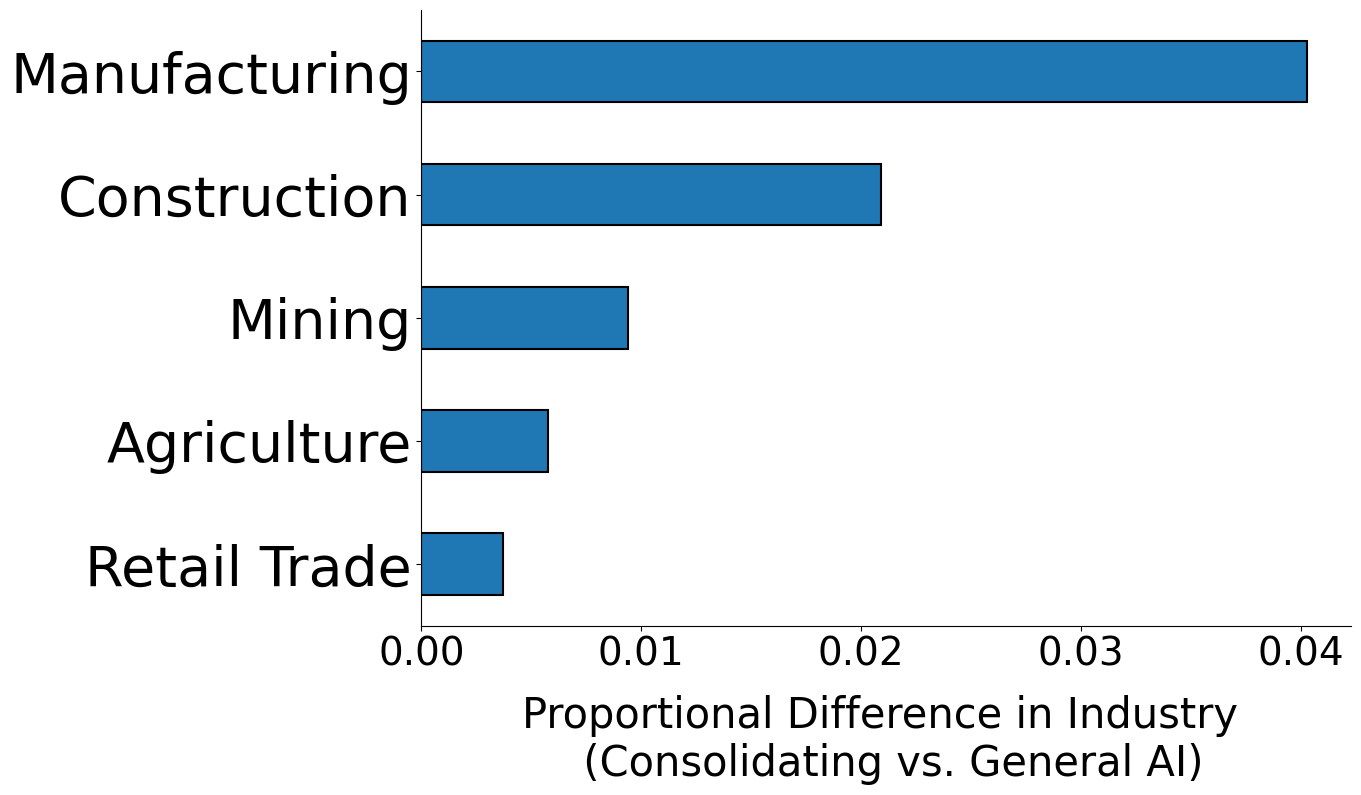

In [64]:
import matplotlib.pyplot as plt

# Set the style to a more professional one
plt.style.use('default')


['Manufacturing',
'Construction',                                                           
'Mining',                                                 
'Agriculture, forestry, fishing and hunting',
'Retail Trade' ]


# Create the figure and axis
plt.figure(figsize=(12, 8))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Plot the data
ranked_difference[:5].sort_values(ascending=True).plot(kind='barh', color='#1f77b4', edgecolor='black', linewidth=1.5)

# Add labels and titles with larger font sizes
plt.xlabel('Proportional Difference in Industry \n (Consolidating vs. General AI)', fontsize=30, labelpad=15)
plt.xticks([0, 0.01, 0.02, 0.03, 0.04], fontsize=28)
plt.yticks([4,3,2,1,0],['Manufacturing',
'Construction',                                                           
'Mining',                                                 
'Agriculture',
'Retail Trade' ], fontsize=40)
plt.ylabel('')

# Adjust the layout and font for the title
# plt.title('Top 5 Industries with the Highest Proportional Increase in Tasks Impacted by Disruptive AI Compared to General AI', fontsize=24, pad=20)

# Save the figure with a higher DPI for better quality
# plt.savefig('Top5_Consolidating_Industry_Tasks.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
